# Importações

In [1]:
import pandas as pd

In [2]:
df_combined = pd.read_parquet('/home/linguica/isabelle/testeModelo/df_result_combined.parquet')

In [3]:
df_combined.head()

,KNR,ID,DATA,HALLE,FALHA
0,2023-5076008,718,2024-02-02 08:03:03,ZP5A,PAINEL LATERAL 08. FALTA VERNIZ
1,2023-5076008,718,2024-02-02 08:03:03,ZP5A,Painel lateral Falta Verniz
2,2023-5076008,718,2024-02-02 07:37:59,ZP5A,PAINEL LATERAL 08. FALTA VERNIZ
3,2023-5076008,718,2024-02-02 07:37:59,ZP5A,Painel lateral Falta Verniz
4,2023-5076008,718,2024-02-02 08:32:14,ZP5A,PAINEL LATERAL 08. FALTA VERNIZ


## Tratameto da coluna 'DATA' para padronização do formato dos dados

In [4]:
# Primeiro, tenta converter diretamente, assumindo que a maioria dos valores tenha milissegundos
df_combined['DATA_FORMATADA'] = pd.to_datetime(df_combined['DATA'], format="%Y-%m-%d %H:%M:%S.%f", errors='coerce')

# Agora, lida com aqueles que falharam (são NaT) e tenta converter sem milissegundos
df_combined['DATA_FORMATADA'].fillna(pd.to_datetime(df_combined['DATA'], format="%Y-%m-%d %H:%M:%S", errors='coerce'), inplace=True)

/tmp/ipykernel_66915/557203965.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['DATA_FORMATADA'].fillna(pd.to_datetime(df_combined['DATA'], format="%Y-%m-%d %H:%M:%S", errors='coerce'), inplace=True)


In [5]:
df_combined.head()

,KNR,ID,DATA,HALLE,FALHA,DATA_FORMATADA
0,2023-5076008,718,2024-02-02 08:03:03,ZP5A,PAINEL LATERAL 08. FALTA VERNIZ,2024-02-02 08:03:03
1,2023-5076008,718,2024-02-02 08:03:03,ZP5A,Painel lateral Falta Verniz,2024-02-02 08:03:03
2,2023-5076008,718,2024-02-02 07:37:59,ZP5A,PAINEL LATERAL 08. FALTA VERNIZ,2024-02-02 07:37:59
3,2023-5076008,718,2024-02-02 07:37:59,ZP5A,Painel lateral Falta Verniz,2024-02-02 07:37:59
4,2023-5076008,718,2024-02-02 08:32:14,ZP5A,PAINEL LATERAL 08. FALTA VERNIZ,2024-02-02 08:32:14


## Criação de novas colunas: "SomaTempo1", "SomaTempo2" e "SomaTempo718"

As colunas foram criadas a partir dos dados da coluna KNR, ID, HALLE e DATA com o objetivo de determinar quanto tempo cada KNR levou em cada ID.

In [6]:

# Ordenar por KNR e DATA_FORMATADA para garantir que os cálculos temporais estejam corretos
df_result_combined = df_combined.sort_values(by=['KNR', 'DATA_FORMATADA'])

# Calcular o tempo entre falhas consecutivas dentro do mesmo carro (KNR) e estação (ID)
df_result_combined['TEMPO'] = df_result_combined.groupby(['KNR', 'ID', 'HALLE'])['DATA_FORMATADA'].diff().fillna(pd.Timedelta(seconds=0))

# Somar o tempo gasto em cada estação (ID) por cada carro (KNR)
tempo_por_estacao = df_result_combined.groupby(['KNR', 'ID'])['TEMPO'].sum().reset_index()

# Criar um DataFrame pivotado para armazenar a soma de tempo em colunas separadas para cada ID
resultado = tempo_por_estacao.pivot(index='KNR', columns='ID', values='TEMPO').fillna(pd.Timedelta(seconds=0))

# Renomear as colunas para o formato desejado
resultado.columns = ['SomaTempo1' if col == 1 else 
                     'SomaTempo2' if col == 2 else 
                     'SomaTempo718' if col == 718 else f'SomaTempo_{col}' for col in resultado.columns]

# Resetar o índice para transformar KNR em coluna
resultado = resultado.reset_index()

# Exibir o resultado final
print(resultado)


                KNR      SomaTempo1       SomaTempo2     SomaTempo718
0      2023-2016173 0 days 00:00:00  0 days 00:00:40  0 days 10:15:26
1      2023-2026098 0 days 00:00:00  0 days 00:00:03  0 days 09:38:18
2      2023-2026162 0 days 00:00:00  0 days 00:00:10  0 days 02:15:14
3      2023-2026175 0 days 00:00:00  0 days 00:00:18  2 days 06:06:06
4      2023-2026215 0 days 00:00:00  0 days 00:00:20 12 days 20:23:08
...             ...             ...              ...              ...
47201  2024-1726002 0 days 02:44:50 44 days 02:45:04 16 days 03:06:34
47202  2024-1726003 0 days 01:19:44 20 days 09:51:10  4 days 07:37:07
47203  2024-1726006 0 days 01:21:43 29 days 08:06:12 12 days 14:09:16
47204  2024-1916086 0 days 02:48:40 64 days 14:17:28 37 days 16:08:26
47205  2024-2016184 0 days 01:19:55 21 days 22:01:43 13 days 01:04:31

[47206 rows x 4 columns]


In [7]:
resultado

,KNR,SomaTempo1,SomaTempo2,SomaTempo718
0,2023-2016173,0 days 00:00:00,0 days 00:00:40,0 days 10:15:26
1,2023-2026098,0 days 00:00:00,0 days 00:00:03,0 days 09:38:18
2,2023-2026162,0 days 00:00:00,0 days 00:00:10,0 days 02:15:14
3,2023-2026175,0 days 00:00:00,0 days 00:00:18,2 days 06:06:06
4,2023-2026215,0 days 00:00:00,0 days 00:00:20,12 days 20:23:08
...,...,...,...,...
47201,2024-1726002,0 days 02:44:50,44 days 02:45:04,16 days 03:06:34
47202,2024-1726003,0 days 01:19:44,20 days 09:51:10,4 days 07:37:07
47203,2024-1726006,0 days 01:21:43,29 days 08:06:12,12 days 14:09:16
47204,2024-1916086,0 days 02:48:40,64 days 14:17:28,37 days 16:08:26


In [8]:
import pandas as pd

linhas_acima_de_um_dia = resultado[
    (resultado['SomaTempo1'] > pd.Timedelta(days=1)) |
    (resultado['SomaTempo2'] > pd.Timedelta(days=1)) |
    (resultado['SomaTempo718'] > pd.Timedelta(days=1))
]

num_linhas_acima_de_um_dia = len(linhas_acima_de_um_dia)

print(f"{num_linhas_acima_de_um_dia} acima a um dia.")


45325 acima a um dia.


In [9]:
import pandas as pd

linhas_acima_de_um_dia_1 = resultado[
    (resultado['SomaTempo1'] > pd.Timedelta(days=1))
]

num_linhas_acima_de_um_dia_1 = len(linhas_acima_de_um_dia_1)

print(f"{num_linhas_acima_de_um_dia_1} linhas estão acima de um dia em SomaTempo1.")


2369 linhas estão acima de um dia em SomaTempo1.


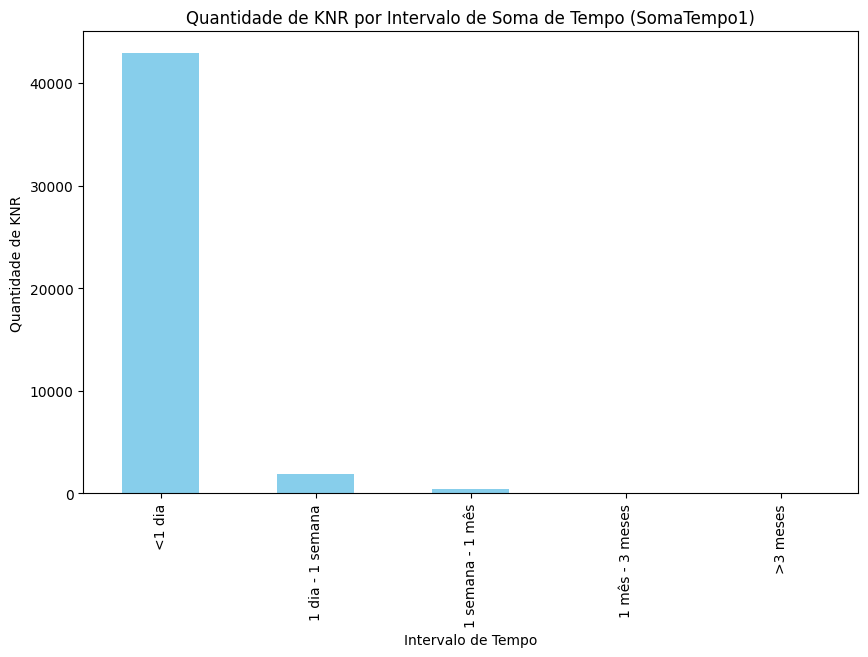

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Criar intervalos de tempo para agrupar os dado
bins = [pd.Timedelta(days=0), pd.Timedelta(days=1), pd.Timedelta(days=7), pd.Timedelta(days=30), pd.Timedelta(days=90), pd.Timedelta(days=365)]
labels = ['<1 dia', '1 dia - 1 semana', '1 semana - 1 mês', '1 mês - 3 meses', '>3 meses']

# quantidade de KNR por faixa de SomaTempo1
resultado['Intervalo_SomaTempo1'] = pd.cut(resultado['SomaTempo1'], bins=bins, labels=labels)
contagem_por_tempo = resultado['Intervalo_SomaTempo1'].value_counts().sort_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
contagem_por_tempo.plot(kind='bar', color='skyblue')

plt.title('Quantidade de KNR por Intervalo de Soma de Tempo (SomaTempo1)')
plt.xlabel('Intervalo de Tempo')
plt.ylabel('Quantidade de KNR')

# Exibir o gráfico
plt.show()


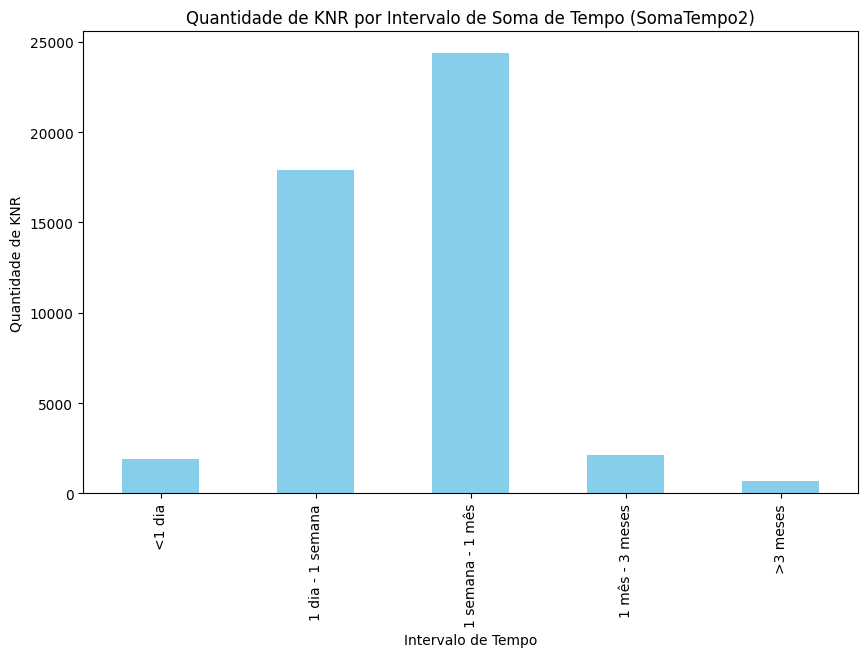

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Criar intervalos de tempo para agrupar os dado
bins = [pd.Timedelta(days=0), pd.Timedelta(days=1), pd.Timedelta(days=7), pd.Timedelta(days=30), pd.Timedelta(days=90), pd.Timedelta(days=365)]
labels = ['<1 dia', '1 dia - 1 semana', '1 semana - 1 mês', '1 mês - 3 meses', '>3 meses']

# quantidade de KNR por faixa de SomaTempo1
resultado['Intervalo_SomaTempo2'] = pd.cut(resultado['SomaTempo2'], bins=bins, labels=labels)
contagem_por_tempo = resultado['Intervalo_SomaTempo2'].value_counts().sort_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
contagem_por_tempo.plot(kind='bar', color='skyblue')

plt.title('Quantidade de KNR por Intervalo de Soma de Tempo (SomaTempo2)')
plt.xlabel('Intervalo de Tempo')
plt.ylabel('Quantidade de KNR')

# Exibir o gráfico
plt.show()


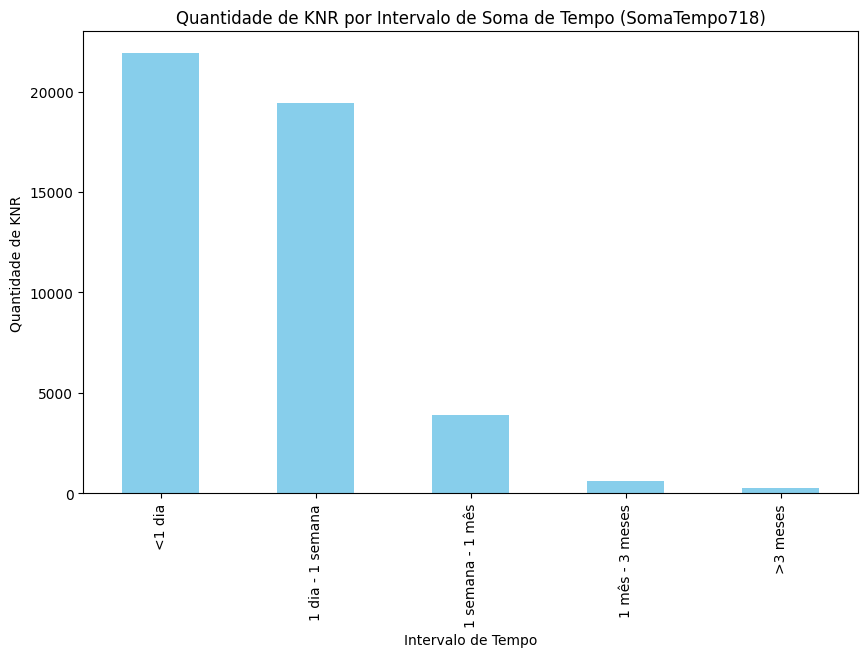

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Criar intervalos de tempo para agrupar os dado
bins = [pd.Timedelta(days=0), pd.Timedelta(days=1), pd.Timedelta(days=7), pd.Timedelta(days=30), pd.Timedelta(days=90), pd.Timedelta(days=365)]
labels = ['<1 dia', '1 dia - 1 semana', '1 semana - 1 mês', '1 mês - 3 meses', '>3 meses']

# quantidade de KNR por faixa de SomaTempo1
resultado['Intervalo_SomaTempo718'] = pd.cut(resultado['SomaTempo718'], bins=bins, labels=labels)
contagem_por_tempo = resultado['Intervalo_SomaTempo718'].value_counts().sort_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
contagem_por_tempo.plot(kind='bar', color='skyblue')

plt.title('Quantidade de KNR por Intervalo de Soma de Tempo (SomaTempo718)')
plt.xlabel('Intervalo de Tempo')
plt.ylabel('Quantidade de KNR')

# Exibir o gráfico
plt.show()


In [13]:
df_result_combined

,KNR,ID,DATA,HALLE,FALHA,DATA_FORMATADA,TEMPO
31136355,2023-2016173,2,2023-06-06 07:07:10,ZP5A,Porta traseira 01. Amassado,2023-06-06 07:07:10,0 days
31136356,2023-2016173,2,2023-06-06 07:07:10,ZP5A,Porta dianteira Fervido,2023-06-06 07:07:10,0 days
31136357,2023-2016173,2,2023-06-06 07:07:10,ZP5A,Painel lateral Fervido,2023-06-06 07:07:10,0 days
31136358,2023-2016173,2,2023-06-06 07:07:10,ZP5A,Painel lateral Repintura (spot),2023-06-06 07:07:10,0 days
31136359,2023-2016173,2,2023-06-06 07:07:10,ZP5A,Porta dianteira Fervido,2023-06-06 07:07:10,0 days
...,...,...,...,...,...,...,...
31136342,2024-2016184,718,2024-04-23 11:45:31,ZP5A,PAINEL LATERAL 05. SUJEIRA NA PINTURA,2024-04-23 11:45:31,0 days
31136343,2024-2016184,718,2024-04-23 11:45:31,ZP5A,PAINEL LATERAL 05. SUJEIRA NA PINTURA,2024-04-23 11:45:31,0 days
31136344,2024-2016184,718,2024-04-23 11:45:31,ZP5A,PAINEL LATERAL 05. SUJEIRA NA PINTURA,2024-04-23 11:45:31,0 days
31136345,2024-2016184,718,2024-04-23 11:45:31,ZP5A,PAINEL LATERAL 05. SUJEIRA NA PINTURA,2024-04-23 11:45:31,0 days


## Criação de novas colunas: "NVezes1", "NVezes2" e "NVezes718"

As colunas foram criadas a partir dos dados da coluna KNR e ID com o objetivo de determinar quantas vezes cada KNR esteve associado a um mesmo ID.

In [14]:
# Contar o número de ocorrências de cada ID para cada KNR
nvezes_por_estacao = df_result_combined.groupby(['KNR', 'ID']).size().reset_index(name='Contagem')

# Criar um DataFrame pivotado para armazenar a contagem em colunas separadas para cada ID
nvezes_resultado = nvezes_por_estacao.pivot(index='KNR', columns='ID', values='Contagem').fillna(0)

# Renomear as colunas para o formato desejado
nvezes_resultado.columns = ['Nvezes1' if col == 1 else 
                            'Nvezes2' if col == 2 else 
                            'Nvezes718' if col == 718 else f'Nvezes_{col}' for col in nvezes_resultado.columns]

# Resetar o índice para transformar KNR em coluna
nvezes_resultado = nvezes_resultado.reset_index()

# Exibir o resultado final
print(nvezes_resultado)


                KNR  Nvezes1  Nvezes2  Nvezes718
0      2023-2016173      0.0     16.0       40.0
1      2023-2026098      0.0     20.0       90.0
2      2023-2026162      0.0     20.0       50.0
3      2023-2026175      0.0     14.0       49.0
4      2023-2026215      0.0     26.0       91.0
...             ...      ...      ...        ...
47201  2024-1726002     54.0   2052.0       90.0
47202  2024-1726003      6.0    226.0       10.0
47203  2024-1726006      6.0    224.0        9.0
47204  2024-1916086     54.0   2106.0      198.0
47205  2024-2016184     48.0   1832.0       88.0

[47206 rows x 4 columns]


In [15]:
df_result_combined['HALLE'].unique()

array(['ZP5A', 'ZP7', 'ZP5', 'ZP6', 'ZP61', 'ZP62', 'ZP5 ', 'ZP6 ',
       'ZP7 '], dtype=object)

In [16]:

# Filtrar o DataFrame para conter apenas as falhas ZP5 e ZP6
df_falhas = df_result_combined[df_result_combined['HALLE'].isin(['ZP5', 'ZP6'])]

# Contar o número de ocorrências de ZP5 e ZP6 para cada KNR
nfalhas_por_halle = df_falhas.groupby(['KNR', 'HALLE']).size().reset_index(name='Contagem')

# Criar um DataFrame pivotado para armazenar as contagens em colunas separadas para ZP5 e ZP6
nfalhas_resultado = nfalhas_por_halle.pivot(index='KNR', columns='HALLE', values='Contagem').fillna(0)

# Renomear as colunas para o formato desejado
nfalhas_resultado.columns = ['NfalhasZP5' if col == 'ZP5' else 
                             'NfalhasZP6' if col == 'ZP6' else col for col in nfalhas_resultado.columns]

# Resetar o índice para transformar KNR em coluna
nfalhas_resultado = nfalhas_resultado.reset_index()

# Exibir o resultado final
print(nfalhas_resultado)


                KNR  NfalhasZP5  NfalhasZP6
0      2023-2026098        44.0        11.0
1      2023-2026162         7.0         0.0
2      2023-2026175         9.0         0.0
3      2023-2026215        18.0         0.0
4      2023-2026405         7.0         0.0
...             ...         ...         ...
26038  2024-1326428       696.0         0.0
26039  2024-1326443       500.0       750.0
26040  2024-1326479       241.0         0.0
26041  2024-1326483       239.0         0.0
26042  2024-1336079       240.0       240.0

[26043 rows x 3 columns]


In [17]:
resultado

,KNR,SomaTempo1,SomaTempo2,SomaTempo718,Intervalo_SomaTempo1,Intervalo_SomaTempo2,Intervalo_SomaTempo718
0,2023-2016173,0 days 00:00:00,0 days 00:00:40,0 days 10:15:26,NaN,<1 dia,<1 dia
1,2023-2026098,0 days 00:00:00,0 days 00:00:03,0 days 09:38:18,NaN,<1 dia,<1 dia
2,2023-2026162,0 days 00:00:00,0 days 00:00:10,0 days 02:15:14,NaN,<1 dia,<1 dia
3,2023-2026175,0 days 00:00:00,0 days 00:00:18,2 days 06:06:06,NaN,<1 dia,1 dia - 1 semana
4,2023-2026215,0 days 00:00:00,0 days 00:00:20,12 days 20:23:08,NaN,<1 dia,1 semana - 1 mês
...,...,...,...,...,...,...,...
47201,2024-1726002,0 days 02:44:50,44 days 02:45:04,16 days 03:06:34,<1 dia,1 mês - 3 meses,1 semana - 1 mês
47202,2024-1726003,0 days 01:19:44,20 days 09:51:10,4 days 07:37:07,<1 dia,1 semana - 1 mês,1 dia - 1 semana
47203,2024-1726006,0 days 01:21:43,29 days 08:06:12,12 days 14:09:16,<1 dia,1 semana - 1 mês,1 semana - 1 mês
47204,2024-1916086,0 days 02:48:40,64 days 14:17:28,37 days 16:08:26,<1 dia,1 mês - 3 meses,1 mês - 3 meses


In [18]:
nvezes_resultado

,KNR,Nvezes1,Nvezes2,Nvezes718
0,2023-2016173,0.0,16.0,40.0
1,2023-2026098,0.0,20.0,90.0
2,2023-2026162,0.0,20.0,50.0
3,2023-2026175,0.0,14.0,49.0
4,2023-2026215,0.0,26.0,91.0
...,...,...,...,...
47201,2024-1726002,54.0,2052.0,90.0
47202,2024-1726003,6.0,226.0,10.0
47203,2024-1726006,6.0,224.0,9.0
47204,2024-1916086,54.0,2106.0,198.0


In [19]:
nfalhas_resultado

,KNR,NfalhasZP5,NfalhasZP6
0,2023-2026098,44.0,11.0
1,2023-2026162,7.0,0.0
2,2023-2026175,9.0,0.0
3,2023-2026215,18.0,0.0
4,2023-2026405,7.0,0.0
...,...,...,...
26038,2024-1326428,696.0,0.0
26039,2024-1326443,500.0,750.0
26040,2024-1326479,241.0,0.0
26041,2024-1326483,239.0,0.0


In [20]:
import pandas as pd

df_combined_final_monstro = pd.merge(nvezes_resultado, resultado, on='KNR')



In [21]:
df_combined_final_monstro

,KNR,Nvezes1,Nvezes2,Nvezes718,SomaTempo1,SomaTempo2,SomaTempo718,Intervalo_SomaTempo1,Intervalo_SomaTempo2,Intervalo_SomaTempo718
0,2023-2016173,0.0,16.0,40.0,0 days 00:00:00,0 days 00:00:40,0 days 10:15:26,NaN,<1 dia,<1 dia
1,2023-2026098,0.0,20.0,90.0,0 days 00:00:00,0 days 00:00:03,0 days 09:38:18,NaN,<1 dia,<1 dia
2,2023-2026162,0.0,20.0,50.0,0 days 00:00:00,0 days 00:00:10,0 days 02:15:14,NaN,<1 dia,<1 dia
3,2023-2026175,0.0,14.0,49.0,0 days 00:00:00,0 days 00:00:18,2 days 06:06:06,NaN,<1 dia,1 dia - 1 semana
4,2023-2026215,0.0,26.0,91.0,0 days 00:00:00,0 days 00:00:20,12 days 20:23:08,NaN,<1 dia,1 semana - 1 mês
...,...,...,...,...,...,...,...,...,...,...
47201,2024-1726002,54.0,2052.0,90.0,0 days 02:44:50,44 days 02:45:04,16 days 03:06:34,<1 dia,1 mês - 3 meses,1 semana - 1 mês
47202,2024-1726003,6.0,226.0,10.0,0 days 01:19:44,20 days 09:51:10,4 days 07:37:07,<1 dia,1 semana - 1 mês,1 dia - 1 semana
47203,2024-1726006,6.0,224.0,9.0,0 days 01:21:43,29 days 08:06:12,12 days 14:09:16,<1 dia,1 semana - 1 mês,1 semana - 1 mês
47204,2024-1916086,54.0,2106.0,198.0,0 days 02:48:40,64 days 14:17:28,37 days 16:08:26,<1 dia,1 mês - 3 meses,1 mês - 3 meses


In [22]:
# df_combined_final_monstro.to_csv('df_combined_final_monstro.csv')

In [49]:
df_falha = pd.read_csv("/home/linguica/isabelle/testeModelo/FALHAS_PREDICT.csv", )

In [50]:
df_falha

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,82662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,KNR,MODELO,COR,MOTOR,ESTACAO,USUARIO,HALLE,FALHA,DATA
2,NaN,2023-1326197,T-CROSS,0Q0Q,DHS,PCEQS100,2043521,ZP5,Porta dianteira Folga (Ajuste),2023-01-09 22:24:44.272000
3,NaN,2023-1326197,T-CROSS,0Q0Q,DHS,PCEQS100,2043521,ZP5,Porta traseira Folga (Ajuste),2023-01-09 22:25:02.960000
4,NaN,2023-4130482,AUDI Q3,2Y2Y,DSN,PCEQS999,2054701,ESPC,Lanterna tras (09) Interfere,2023-01-10 09:18:25.238000
...,...,...,...,...,...,...,...,...,...,...
663816,NaN,2024-1336453,T-CROSS,K2K2,DHS,HCEQS506,2051427,ZP7,TAMPA TRASEIRA 05. SUJEIRA NA PINTURA,2024-03-27 14:52:39.400000
663817,NaN,2024-1336485,T-CROSS,0Q0Q,DHS,HCEQS506,2044862,ZP7,PORTA TRASEIRA 03. CAVACO,2024-03-27 14:53:03.187000
663818,NaN,2024-1346004,T-CROSS,A1A1,DHS,HCEQS506,2052733,ZP7,RACK DO TETO FELTRO APARENTE,2024-03-27 14:53:25.992000
663819,NaN,2024-1336453,T-CROSS,K2K2,DHS,HCEQS506,2051427,ZP7,TAMPA TRASEIRA 07. FERVIDO,2024-03-27 14:53:29.873000


In [47]:
df_falha.columns

Index([], dtype='object')

In [51]:
df_falha.columns = df_falha.iloc[1]

In [54]:
df_falha = df_falha.drop([0, 1])

In [55]:
df_falha

1,NaN,KNR,MODELO,COR,MOTOR,ESTACAO,USUARIO,HALLE,FALHA,DATA
2,NaN,2023-1326197,T-CROSS,0Q0Q,DHS,PCEQS100,2043521,ZP5,Porta dianteira Folga (Ajuste),2023-01-09 22:24:44.272000
3,NaN,2023-1326197,T-CROSS,0Q0Q,DHS,PCEQS100,2043521,ZP5,Porta traseira Folga (Ajuste),2023-01-09 22:25:02.960000
4,NaN,2023-4130482,AUDI Q3,2Y2Y,DSN,PCEQS999,2054701,ESPC,Lanterna tras (09) Interfere,2023-01-10 09:18:25.238000
5,NaN,2023-4130482,AUDI Q3,2Y2Y,DSN,PCEQS999,2054701,ESPC,Emblema / logo - Adesivos em geral Solto(a) ¨,2023-01-10 09:18:40.728000
6,NaN,2023-4130664,AUDI Q3,6Y6Y,DSN,PCEQS805,7000240,ZP82,Painel instrumentos Ruído (-),2023-01-10 11:17:56.489000
...,...,...,...,...,...,...,...,...,...,...
663816,NaN,2024-1336453,T-CROSS,K2K2,DHS,HCEQS506,2051427,ZP7,TAMPA TRASEIRA 05. SUJEIRA NA PINTURA,2024-03-27 14:52:39.400000
663817,NaN,2024-1336485,T-CROSS,0Q0Q,DHS,HCEQS506,2044862,ZP7,PORTA TRASEIRA 03. CAVACO,2024-03-27 14:53:03.187000
663818,NaN,2024-1346004,T-CROSS,A1A1,DHS,HCEQS506,2052733,ZP7,RACK DO TETO FELTRO APARENTE,2024-03-27 14:53:25.992000
663819,NaN,2024-1336453,T-CROSS,K2K2,DHS,HCEQS506,2051427,ZP7,TAMPA TRASEIRA 07. FERVIDO,2024-03-27 14:53:29.873000


## Filtrando para que apenas as falhas de rodagem estejam presentes no dataset

In [56]:
df_filtrado = df_falha[df_falha['HALLE'] == 'ROD']

In [58]:
df_falha = df_filtrado.reset_index(drop=True)


In [59]:
df_falha['HALLE'].unique()

array(['ROD'], dtype=object)

In [60]:
df_falha

1,NaN,KNR,MODELO,COR,MOTOR,ESTACAO,USUARIO,HALLE,FALHA,DATA
0,NaN,2023-4150504,AUDI Q3,6Y6Y,DSN,PCEQS709,2049783,ROD,Iluminação central interna (09) Ruído de corpo...,2023-01-11 14:34:02.419000
1,NaN,2023-4210026,AUDI Q3,0E0E,DSN,PCEQS709,2034913,ROD,Painel instrumentos Ruído (-),2023-01-12 12:22:12.447000
2,NaN,2023-4240490,AUDI Q3,6Y6Y,DSN,PCEQS709,2034913,ROD,Painel instrumentos Ruído (-),2023-01-13 13:48:25.650000
3,NaN,2023-4330463,AUDI Q3,2Y2Y,DSN,PCEQS709,2049783,ROD,Mangueira do compressor (Alta pressão) Parafus...,2023-01-17 12:50:00.768000
4,NaN,2023-4510234,AUDI Q3,Z7Z7,DSN,PCEQS709,2034913,ROD,Revestimento coluna B Ruído de peça solta,2023-01-17 13:58:18.102000
...,...,...,...,...,...,...,...,...,...,...
5928,NaN,2024-1246414,T-CROSS,0Q0Q,DRP,PCEQS709,2049732,ROD,Tampa traseira Ruído (-),2024-03-22 18:39:58.187000
5929,NaN,2024-1256233,T-CROSS,A1A1,DHS,PCEQS709,2057190,ROD,Console central Ruído (-),2024-03-22 18:43:13.140000
5930,NaN,2024-1316099,T-CROSS,5T5T,CWL,PCEQS709,4003084,ROD,Tampa traseira Ruído (-),2024-03-22 20:10:22.099000
5931,NaN,2024-1316101,T-CROSS,5T5T,CWL,PCEQS709,4003084,ROD,Teto/teto moldado (cheio) Ruído (-),2024-03-22 20:18:34.517000


In [62]:
# Criar um conjunto com os valores de KNR da tabela df_falha
knr_set = set(df_falha['KNR'])

knr_set

{'2023-4856114',
 '2023-2016041',
 '2023-4826199',
 '2023-2026236',
 '2023-4526433',
 '2023-1316143',
 '2023-0626237',
 '2023-0646319',
 '2023-3026194',
 '2024-0816686',
 '2023-0210532',
 '2023-4626244',
 '2023-3616052',
 '2023-0546432',
 '2023-3720505',
 '2023-4746223',
 '2024-0826201',
 '2023-0526364',
 '2024-0426066',
 '2023-1826171',
 '2024-0756164',
 '2023-1116343',
 '2023-1446473',
 '2024-0856464',
 '2023-4556193',
 '2023-3816021',
 '2023-3056226',
 '2023-4726057',
 '2023-3516279',
 '2023-1356384',
 '2023-2856093',
 '2023-1116093',
 '2023-1326017',
 '2024-1256156',
 '2023-3546199',
 '2023-2516144',
 '2023-0536082',
 '2023-2136359',
 '2023-3016123',
 '2023-4426052',
 '2023-1436015',
 '2023-1836048',
 '2023-4756417',
 '2023-2636165',
 '2023-2656310',
 '2024-0356134',
 '2023-1926226',
 '2023-1426462',
 '2023-1326108',
 '2023-4816005',
 '2023-3876014',
 '2023-2746262',
 '2023-1326163',
 '2023-1426116',
 '2023-1356266',
 '2023-1846218',
 '2023-1856095',
 '2023-1446485',
 '2024-0616194

In [63]:
df_combined_final_monstro['TemFalhaRod'] = df_combined_final_monstro['KNR'].apply(lambda x: 1 if x in knr_set else 0)


In [64]:
df_combined_final_monstro

,KNR,Nvezes1,Nvezes2,Nvezes718,SomaTempo1,SomaTempo2,SomaTempo718,Intervalo_SomaTempo1,Intervalo_SomaTempo2,Intervalo_SomaTempo718,TemFalhaRod
0,2023-2016173,0.0,16.0,40.0,0 days 00:00:00,0 days 00:00:40,0 days 10:15:26,NaN,<1 dia,<1 dia,0
1,2023-2026098,0.0,20.0,90.0,0 days 00:00:00,0 days 00:00:03,0 days 09:38:18,NaN,<1 dia,<1 dia,1
2,2023-2026162,0.0,20.0,50.0,0 days 00:00:00,0 days 00:00:10,0 days 02:15:14,NaN,<1 dia,<1 dia,0
3,2023-2026175,0.0,14.0,49.0,0 days 00:00:00,0 days 00:00:18,2 days 06:06:06,NaN,<1 dia,1 dia - 1 semana,0
4,2023-2026215,0.0,26.0,91.0,0 days 00:00:00,0 days 00:00:20,12 days 20:23:08,NaN,<1 dia,1 semana - 1 mês,0
...,...,...,...,...,...,...,...,...,...,...,...
47201,2024-1726002,54.0,2052.0,90.0,0 days 02:44:50,44 days 02:45:04,16 days 03:06:34,<1 dia,1 mês - 3 meses,1 semana - 1 mês,0
47202,2024-1726003,6.0,226.0,10.0,0 days 01:19:44,20 days 09:51:10,4 days 07:37:07,<1 dia,1 semana - 1 mês,1 dia - 1 semana,0
47203,2024-1726006,6.0,224.0,9.0,0 days 01:21:43,29 days 08:06:12,12 days 14:09:16,<1 dia,1 semana - 1 mês,1 semana - 1 mês,0
47204,2024-1916086,54.0,2106.0,198.0,0 days 02:48:40,64 days 14:17:28,37 days 16:08:26,<1 dia,1 mês - 3 meses,1 mês - 3 meses,0


In [70]:
df_combined_final_monstro[df_combined_final_monstro['TemFalhaRod'] == 1]

,KNR,Nvezes1,Nvezes2,Nvezes718,SomaTempo1,SomaTempo2,SomaTempo718,Intervalo_SomaTempo1,Intervalo_SomaTempo2,Intervalo_SomaTempo718,TemFalhaRod
1,2023-2026098,0.0,20.0,90.0,0 days 00:00:00,0 days 00:00:03,0 days 09:38:18,NaN,<1 dia,<1 dia,1
39,2023-2036397,0.0,14.0,42.0,0 days 00:00:00,0 days 00:00:32,0 days 02:05:30,NaN,<1 dia,<1 dia,1
68,2023-2046026,0.0,14.0,35.0,0 days 00:00:00,0 days 00:00:27,0 days 08:38:00,NaN,<1 dia,<1 dia,1
156,2023-2046279,0.0,12.0,36.0,0 days 00:00:00,0 days 00:00:11,0 days 06:25:30,NaN,<1 dia,<1 dia,1
180,2023-2056049,8.0,24.0,112.0,0 days 00:00:00,51 days 16:57:15,51 days 17:11:42,NaN,1 mês - 3 meses,1 mês - 3 meses,1
...,...,...,...,...,...,...,...,...,...,...,...
45019,2024-1256484,132.0,4972.0,176.0,0 days 04:03:39,5 days 15:26:39,0 days 23:44:00,<1 dia,1 dia - 1 semana,<1 dia,1
45120,2024-1316099,60.0,2160.0,80.0,0 days 06:36:10,6 days 21:06:25,1 days 04:55:15,<1 dia,1 dia - 1 semana,1 dia - 1 semana,1
45122,2024-1316101,180.0,6750.0,210.0,0 days 06:49:05,9 days 03:39:55,1 days 08:51:25,<1 dia,1 semana - 1 mês,1 dia - 1 semana,1
45296,2024-1316276,84.0,3248.0,84.0,0 days 04:02:51,86 days 18:30:06,2 days 07:32:18,<1 dia,1 mês - 3 meses,1 dia - 1 semana,1


In [69]:
df_combined_final_monstro[df_combined_final_monstro['TemFalhaRod'] == 0]

,KNR,Nvezes1,Nvezes2,Nvezes718,SomaTempo1,SomaTempo2,SomaTempo718,Intervalo_SomaTempo1,Intervalo_SomaTempo2,Intervalo_SomaTempo718,TemFalhaRod
0,2023-2016173,0.0,16.0,40.0,0 days 00:00:00,0 days 00:00:40,0 days 10:15:26,NaN,<1 dia,<1 dia,0
2,2023-2026162,0.0,20.0,50.0,0 days 00:00:00,0 days 00:00:10,0 days 02:15:14,NaN,<1 dia,<1 dia,0
3,2023-2026175,0.0,14.0,49.0,0 days 00:00:00,0 days 00:00:18,2 days 06:06:06,NaN,<1 dia,1 dia - 1 semana,0
4,2023-2026215,0.0,26.0,91.0,0 days 00:00:00,0 days 00:00:20,12 days 20:23:08,NaN,<1 dia,1 semana - 1 mês,0
5,2023-2026304,0.0,26.0,52.0,0 days 00:00:00,0 days 00:02:00,0 days 03:28:46,NaN,<1 dia,<1 dia,0
...,...,...,...,...,...,...,...,...,...,...,...
47201,2024-1726002,54.0,2052.0,90.0,0 days 02:44:50,44 days 02:45:04,16 days 03:06:34,<1 dia,1 mês - 3 meses,1 semana - 1 mês,0
47202,2024-1726003,6.0,226.0,10.0,0 days 01:19:44,20 days 09:51:10,4 days 07:37:07,<1 dia,1 semana - 1 mês,1 dia - 1 semana,0
47203,2024-1726006,6.0,224.0,9.0,0 days 01:21:43,29 days 08:06:12,12 days 14:09:16,<1 dia,1 semana - 1 mês,1 semana - 1 mês,0
47204,2024-1916086,54.0,2106.0,198.0,0 days 02:48:40,64 days 14:17:28,37 days 16:08:26,<1 dia,1 mês - 3 meses,1 mês - 3 meses,0


In [72]:
df_combined_final_monstro.to_csv('df_combined_final_monstro.csv')

In [75]:
df_combined_sem_intervalos = df_combined_final_monstro.drop(['Intervalo_SomaTempo1', 'Intervalo_SomaTempo2', 'Intervalo_SomaTempo718'], axis=1)

In [76]:
df_combined_sem_intervalos

,KNR,Nvezes1,Nvezes2,Nvezes718,SomaTempo1,SomaTempo2,SomaTempo718,TemFalhaRod
0,2023-2016173,0.0,16.0,40.0,0 days 00:00:00,0 days 00:00:40,0 days 10:15:26,0
1,2023-2026098,0.0,20.0,90.0,0 days 00:00:00,0 days 00:00:03,0 days 09:38:18,1
2,2023-2026162,0.0,20.0,50.0,0 days 00:00:00,0 days 00:00:10,0 days 02:15:14,0
3,2023-2026175,0.0,14.0,49.0,0 days 00:00:00,0 days 00:00:18,2 days 06:06:06,0
4,2023-2026215,0.0,26.0,91.0,0 days 00:00:00,0 days 00:00:20,12 days 20:23:08,0
...,...,...,...,...,...,...,...,...
47201,2024-1726002,54.0,2052.0,90.0,0 days 02:44:50,44 days 02:45:04,16 days 03:06:34,0
47202,2024-1726003,6.0,226.0,10.0,0 days 01:19:44,20 days 09:51:10,4 days 07:37:07,0
47203,2024-1726006,6.0,224.0,9.0,0 days 01:21:43,29 days 08:06:12,12 days 14:09:16,0
47204,2024-1916086,54.0,2106.0,198.0,0 days 02:48:40,64 days 14:17:28,37 days 16:08:26,0
